In [1]:
from rfsoc_mts import mtsOverlay
from pynq import MMIO
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ol=mtsOverlay('mtsDev.bit',"dev")

In [3]:
#method to access the ddr4 memory addresses
baseAddress = 0x1000000000
baseRange=0xFFFFFFFF
offset=0x0
DAC_buffer=MMIO(baseAddress,baseRange)

In [4]:
#just confirming things work the way I think
numberTest=(2**64)-1
#print(bin(numberTest))
#print(numberTest)
#DAC_buffer.write(offset,numberTest)
#DAC_buffer.read(offset)
#print(bin(DAC_buffer.read(offset)))
bin(np.int16(-16383))

'-0b11111111111111'

In [5]:
#params needed to generate the waveform
Fc=200e6
dataLength=(2*1024**2)/(2) #samples are 16 bit each, or 2 byte
dataAddress=dataLength/2 #each address is 32 bits, so holds 2 samples, so need to write to half 
DAC_SR=8e9
DAC_Amplitude = 16383
X_axis=(1/DAC_SR)*np.arange(0,dataLength)

sinewave=[]
for t in X_axis:
    #sinewave.append(DAC_Amplitude)
    sinewave.append((DAC_Amplitude/3)*np.sin(2*np.pi*ol.frequency_round(Fc,DAC_SR)*t)+DAC_Amplitude/2)

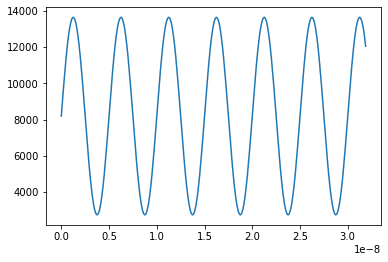

In [9]:
#plot to confirm what the waveform looks like
plt.close()
plt.figure(1)
plt.plot(X_axis[0:256],sinewave[0:256])
plt.show()

In [10]:

#because samples are 16 bit, but the memory addrsses are seperated by 32 bit, need to concat adjacent 16 bit samples into a single 32 bit value
dacBufferWave=[]
for i in range(0,len(sinewave),2):
    MSB=int(sinewave[i+1])<<16 #not actually sure what order these should go in, try both see what works
    LSB=int(sinewave[i])
    sumValue=MSB+LSB
    dacBufferWave.append(sumValue)

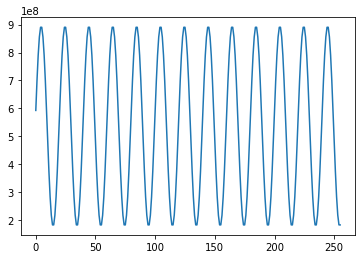

In [12]:
#confirm the concat waveform still follows a sinewave (which it should since it's basically just compressing it)
plt.close()
plt.figure(2)
plt.plot(range(len(dacBufferWave))[0:256],np.int32(dacBufferWave[0:256]))
plt.show()

In [13]:
#write to the ddr4
for i in range(len(dacBufferWave)):
    offsetValue=i*4
    DAC_buffer.write(offsetValue,int(dacBufferWave[i]))

In [14]:
#read the ddr4 out to the cpu 
extractBuffer=[]
for i in range(len(dacBufferWave)):
    offsetValue=i*4
    extractBuffer.append(np.int32(DAC_buffer.read(offsetValue)))

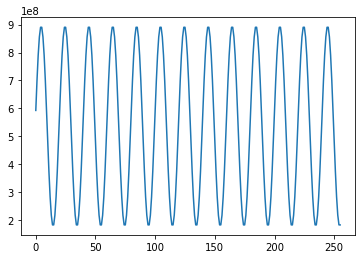

In [15]:
#confirm what got uploaded is the same as what is there
plt.close()
plt.figure(3)
plt.plot(range(len(extractBuffer))[0:256],extractBuffer[0:256])
plt.show()

In [16]:
#just confirm exact numbers are the same using a random index
index=538
print(bin(dacBufferWave[index]))
print(bin(extractBuffer[index]))
print(extractBuffer[index]-dacBufferWave[index])

0b10110010000110001001101101010
0b10110010000110001001101101010
0


In [17]:
#turn dac on to see how it does
ol.dac_enable.off()
ol.dac_enable.on()

In [18]:
ol.dac_enable.off()